In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import CONFIG, TORCH_GEN
from models.vl_encoders import VLE_REGISTRY, MapComputeMode, VLEncoder
from data import image_UIDs, get_many_answer_gt, get_many_answer_pr, CLASS_MAP, flatten_class_splitted_answers, get_sc, get_gt, get_pr
from color_map import apply_colormap, COLOR_MAP_DICT, NUM_CLASSES
from viz import overlay_map, display_token_length_distr, display_prompt
from utils import flatten_list
from path import SCS_PATH, GTS_PATH, get_mask_prs_path
from prompter import get_significant_classes

import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
import seaborn as sns
from pathlib import Path

from typing import Optional

In [3]:
# TODO use Git SubModules to integrate external repos in the project

# Attention Maps

In [4]:
def compute_maps_with_captions(
        model: VLEncoder,
        images: torch.Tensor,
        captions: list[str],
        map_compute_mode: MapComputeMode,
        viz_image_size: Optional[int | list[int]] = None,
        map_resize_mode: TF.InterpolationMode = TF.InterpolationMode.NEAREST,
        normalize: bool = True,
) -> list[tuple[Image.Image, str]]:
    image_text_list = []

    for img, text in zip(images, captions):
        img_tensor = model.preprocess_images([img], device=CONFIG['device'])
        text_tensor = model.preprocess_texts([text], device=CONFIG['device'])
        logits = model.get_logits(img_tensor, text_tensor)
        map, min_value, max_value = model.get_maps(
            img_tensor, text_tensor,
            map_compute_mode=map_compute_mode,
            upsample_size=viz_image_size, upsample_mode=map_resize_mode) # [1, H, W], M
        map = map.squeeze(0) # [1, H, W]
        if viz_image_size:
            img = TF.resize(img, size=viz_image_size, interpolation=TF.InterpolationMode.BILINEAR)
        ovr_img = overlay_map(img, map, normalize=normalize) # (H_viz, W_viz)

        image_text_list.append((ovr_img, f"LOGITS = {logits.item():.2f}", f"MIN VALUE = {min_value.item():.2f}, MAX VALUE = {max_value.item():.2f}", text, "---"))

    return image_text_list

In [5]:
# img_idxs = list(range(0, 8))
img_idxs = [9, 10, 11, 12, 13, 14, 15, 17]
viz_image_size = 300
map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST
normalize = True
alpha = 1.0 # 1.0 --> only scene, 0.0 only mask (0.0, 0.4, 1.0)

image_uids = image_UIDs[img_idxs]

In [6]:
# model = FLAIRAdapter()
model = VLE_REGISTRY.get('flair')

In [7]:
scs_paths = [SCS_PATH / (UID + ".jpg") for UID in image_uids]
scs = [get_sc(p, resize_size=CONFIG['seg']['image_size'], center_crop=True) for p in scs_paths] # tensors (3, H, W)
len(scs)

8

## Non-splitted

In [8]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False, format_to_dict=True)
answers_gt_text = [answers_gt[i] for i in img_idxs]
len(answers_gt_text)

8

### Predictions Masks

In [9]:
mask_prs_paths = [get_mask_prs_path("LRASPP_MobileNet_V3") / f"mask_pr_{i}.png" for i in img_idxs]
mask_prs = [apply_colormap(get_pr(p, class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), COLOR_MAP_DICT, NUM_CLASSES) for p in mask_prs_paths] # tensors (3, H, W)
ovr_mask_prs = [to_tensor(Image.blend(to_pil_image(pr), to_pil_image(sc), alpha=alpha)) for pr, sc in zip(mask_prs, scs)]
len(ovr_mask_prs)

8

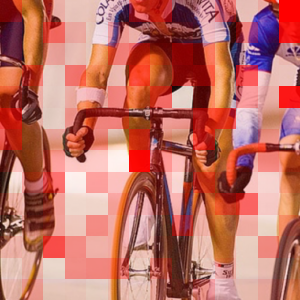

LOGITS = -3.34

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction masks for the ground truth PERSON and BIKE regions are overall coarser and more irregular. The body and the handles of the BIKE regions are in general severely under-segmented, while the PERSON regions are segmented in an erratic, inconsistent way.


---

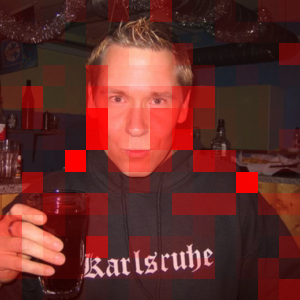

LOGITS = -11.88

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask for the ground truth PERSON region is imperfect, some area has been missed on the bottom-left while some area has been hallucinated on the top edge. Of all the ground truth BOTTLE instances (two on the left half and two on the right half of the scene) have been completely missed by the prediction.


---

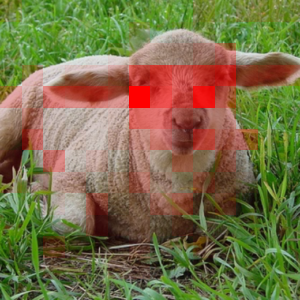

LOGITS = -2.63

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask for the ground truth SHEEP region is incomplete in the top-right corner and in the top-left corner. Moreover, The boundaries are imperfect towards the center-bottom and there is some slight over-extension on the center-bottom-right.


---

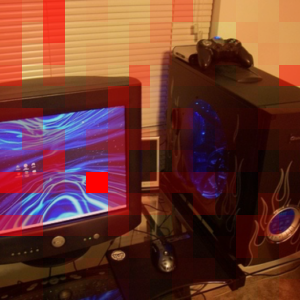

LOGITS = -0.87

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction hallucinated several TVMONITOR patches on the right half of the scene.


---

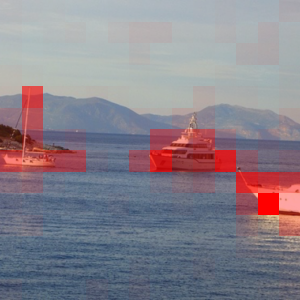

LOGITS = -0.36

MIN VALUE = 0.00, MAX VALUE = 0.05

The ground truth BOAT region on the left has a more blob-like and over-extended shape but its mast has mostly been missed.


---

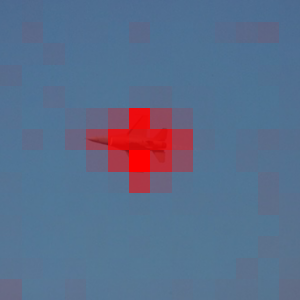

LOGITS = -5.17

MIN VALUE = 0.00, MAX VALUE = 0.07

The prediction mask for the ground truth AEROPLANE region has some slightly coarser boundaries.


---

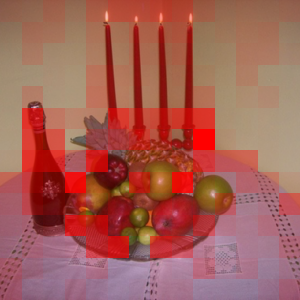

LOGITS = -7.69

MIN VALUE = 0.00, MAX VALUE = 0.02

The ground truth DININGTABLE has been segmented with some irregular, erratic and over-extended boundaries in the center of the scene, and the prediction mask for the ground truth BOTTLE region is under-segmented a bit.


---

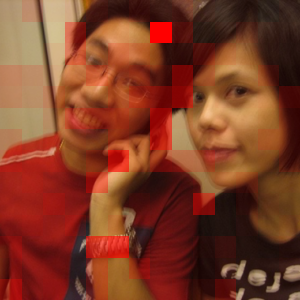

LOGITS = -5.32

MIN VALUE = 0.00, MAX VALUE = 0.03

The boundaries of the prediction mask for the ground truth PERSON region tend to be coarser and over-extended.


---

In [10]:
pr_image_text_list = compute_maps_with_captions(model, ovr_mask_prs, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
display_prompt(flatten_list(pr_image_text_list))

Contrastive analysis:

In [11]:
con_ovr_mask_prs = [ovr_mask_prs[0]]*int(len(ovr_mask_prs)/2) + [ovr_mask_prs[4]]*int(len(ovr_mask_prs)/2)
len(con_ovr_mask_prs)

8

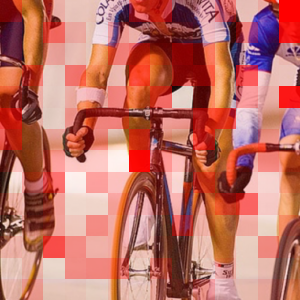

LOGITS = -3.34

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction masks for the ground truth PERSON and BIKE regions are overall coarser and more irregular. The body and the handles of the BIKE regions are in general severely under-segmented, while the PERSON regions are segmented in an erratic, inconsistent way.


---

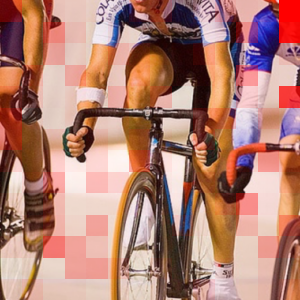

LOGITS = -15.14

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask for the ground truth PERSON region is imperfect, some area has been missed on the bottom-left while some area has been hallucinated on the top edge. Of all the ground truth BOTTLE instances (two on the left half and two on the right half of the scene) have been completely missed by the prediction.


---

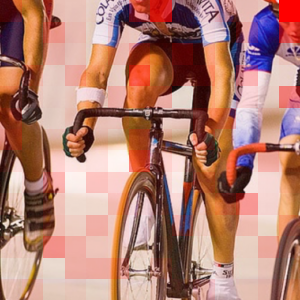

LOGITS = -9.86

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask for the ground truth SHEEP region is incomplete in the top-right corner and in the top-left corner. Moreover, The boundaries are imperfect towards the center-bottom and there is some slight over-extension on the center-bottom-right.


---

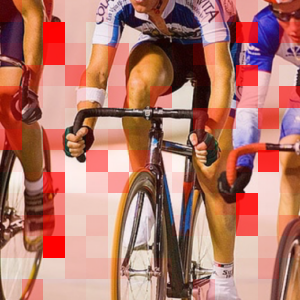

LOGITS = -12.19

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction hallucinated several TVMONITOR patches on the right half of the scene.


---

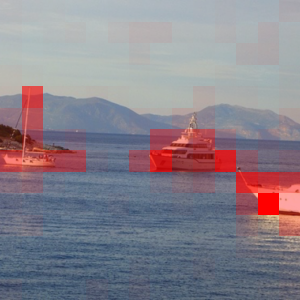

LOGITS = -0.36

MIN VALUE = 0.00, MAX VALUE = 0.05

The ground truth BOAT region on the left has a more blob-like and over-extended shape but its mast has mostly been missed.


---

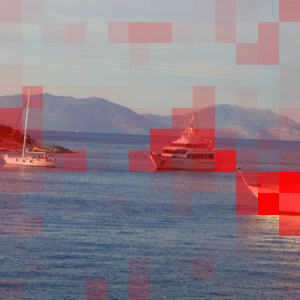

LOGITS = -13.37

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask for the ground truth AEROPLANE region has some slightly coarser boundaries.


---

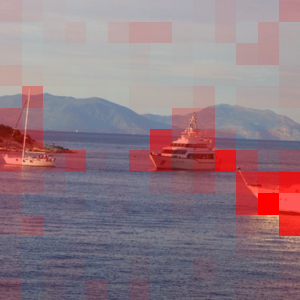

LOGITS = -12.61

MIN VALUE = 0.00, MAX VALUE = 0.03

The ground truth DININGTABLE has been segmented with some irregular, erratic and over-extended boundaries in the center of the scene, and the prediction mask for the ground truth BOTTLE region is under-segmented a bit.


---

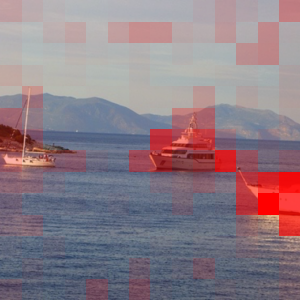

LOGITS = -13.18

MIN VALUE = 0.00, MAX VALUE = 0.04

The boundaries of the prediction mask for the ground truth PERSON region tend to be coarser and over-extended.


---

In [12]:
pr_image_text_list = compute_maps_with_captions(model, con_ovr_mask_prs, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
display_prompt(flatten_list(pr_image_text_list))

### Ground truth masks:

In [13]:
mask_gts_paths = [GTS_PATH / (UID + ".png") for UID in image_uids]
mask_gts = [apply_colormap(get_gt(p, class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), COLOR_MAP_DICT, NUM_CLASSES) for p in mask_gts_paths] # tensors (3, H, W)
ovr_mask_gts = [to_tensor(Image.blend(to_pil_image(gt), to_pil_image(sc), alpha=alpha)) for gt, sc in zip(mask_gts, scs)]
len(ovr_mask_gts)

8

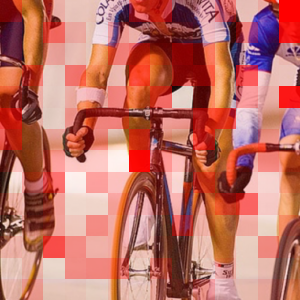

LOGITS = -3.34

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction masks for the ground truth PERSON and BIKE regions are overall coarser and more irregular. The body and the handles of the BIKE regions are in general severely under-segmented, while the PERSON regions are segmented in an erratic, inconsistent way.


---

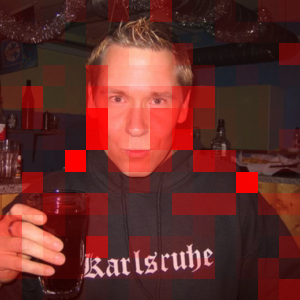

LOGITS = -11.88

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask for the ground truth PERSON region is imperfect, some area has been missed on the bottom-left while some area has been hallucinated on the top edge. Of all the ground truth BOTTLE instances (two on the left half and two on the right half of the scene) have been completely missed by the prediction.


---

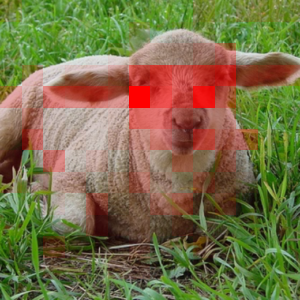

LOGITS = -2.63

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask for the ground truth SHEEP region is incomplete in the top-right corner and in the top-left corner. Moreover, The boundaries are imperfect towards the center-bottom and there is some slight over-extension on the center-bottom-right.


---

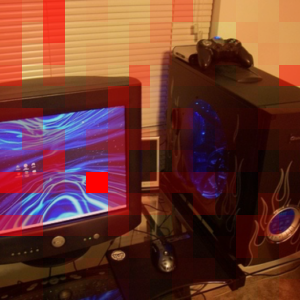

LOGITS = -0.87

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction hallucinated several TVMONITOR patches on the right half of the scene.


---

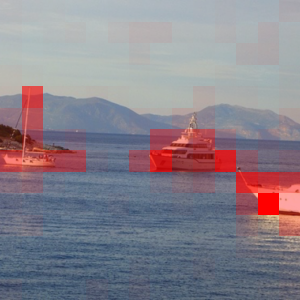

LOGITS = -0.36

MIN VALUE = 0.00, MAX VALUE = 0.05

The ground truth BOAT region on the left has a more blob-like and over-extended shape but its mast has mostly been missed.


---

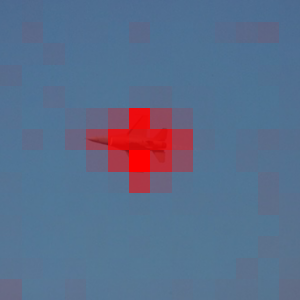

LOGITS = -5.17

MIN VALUE = 0.00, MAX VALUE = 0.07

The prediction mask for the ground truth AEROPLANE region has some slightly coarser boundaries.


---

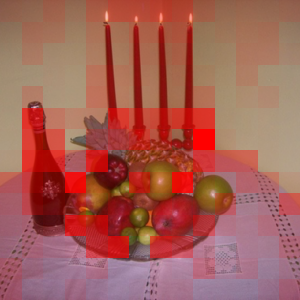

LOGITS = -7.69

MIN VALUE = 0.00, MAX VALUE = 0.02

The ground truth DININGTABLE has been segmented with some irregular, erratic and over-extended boundaries in the center of the scene, and the prediction mask for the ground truth BOTTLE region is under-segmented a bit.


---

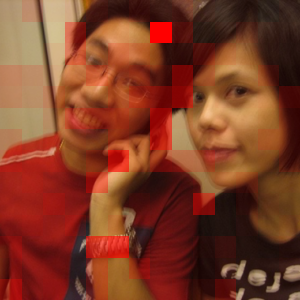

LOGITS = -5.32

MIN VALUE = 0.00, MAX VALUE = 0.03

The boundaries of the prediction mask for the ground truth PERSON region tend to be coarser and over-extended.


---

In [14]:
gt_image_text_list = compute_maps_with_captions(model, ovr_mask_gts, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
display_prompt(flatten_list(gt_image_text_list))

## Class-splitted

### Prediction Masks

In [15]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
cs_answers_pr = get_many_answer_pr(prs_path, return_state=False, format_to_dict=True)
cs_answers_pr_text = [list(cs_answers_pr[i].values()) for i in img_idxs]

In [16]:
significant_classes_pr = [get_significant_classes(get_mask_prs_path("LRASPP_MobileNet_V3") / (f"mask_pr_{i}.png"), CONFIG['seg']['image_size'], CLASS_MAP)  for i in img_idxs]

In [17]:
cs_color_map_dicts = [list({c: [255, 255, 255] if c == pos_class else [0, 0, 0] for c in range(NUM_CLASSES)} for pos_class in classes) for classes in significant_classes_pr]
cs_mask_prs = [list(apply_colormap(get_pr(mask_prs_paths[i], class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True), cs_color_map_dicts[i][t], NUM_CLASSES) for t, pos_class in enumerate(classes)) for i, classes in enumerate(significant_classes_pr)]
cs_ovr_mask_prs = [list(to_tensor(Image.blend(to_pil_image(pr), to_pil_image(sc), alpha=alpha)) for pr in cs_prs) for cs_prs, sc in zip(cs_mask_prs, scs)]
len(cs_ovr_mask_prs)

8

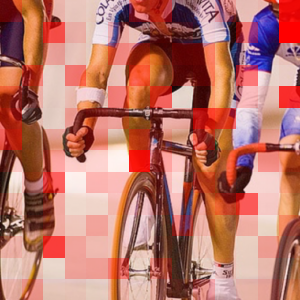

LOGITS = -8.94

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask of the BICYCLE region is quite fragmented and incomplete. It misses significant portions of the frame, particularly around the rear wheel and the lower part of the frame. The boundaries are also quite irregular and not well-defined, showing a lack of precision in the segmentation.

---

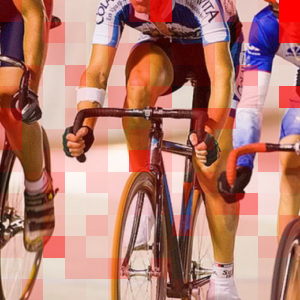

LOGITS = -2.21

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask of the PERSON region is quite accurate overall, but the boundaries are not well-defined, especially around the arms and legs. The mask appears slightly over-extended towards the bicycle.

---

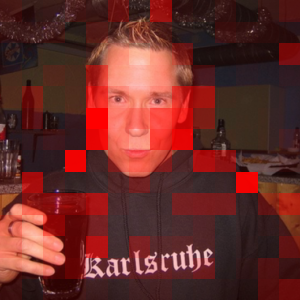

LOGITS = -13.73

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask of the BOTTLE class is quite fragmented. While the general location of the BOTTLE regions is captured, the segmentation is quite coarse and misses several parts of the ground truth BOTTLE regions, particularly around the edges and in the interior.

---

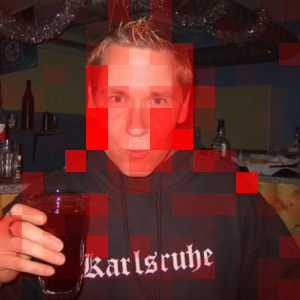

LOGITS = -11.15

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask of the PERSON region is quite accurate overall, but the boundaries are not well-defined, especially around the edges of the face and the hand. There's some leakage into the background regions.

---

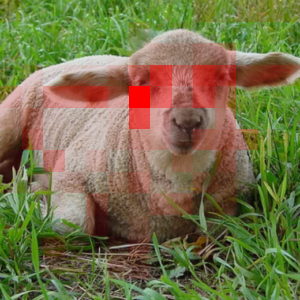

LOGITS = 0.71

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask of the SHEEP region is quite rough and lacks fine details compared to the ground truth. Specifically, the boundary of the SHEEP is not well-defined, with significant gaps and over-extensions towards the bottom and right side of the scene. The ground truth captures the shape of the SHEEP more accurately, while the prediction mask appears more fragmented and less cohesive.

---

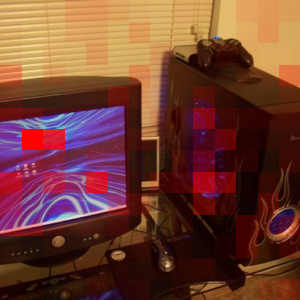

LOGITS = -4.32

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask for the TVMONITOR region is quite fragmented and noisy. It fails to accurately capture the entire TVMONITOR area, exhibiting several isolated white patches around the edges and on the right side of the screen. The ground truth TVMONITOR region is segmented much more consistently and completely.

---

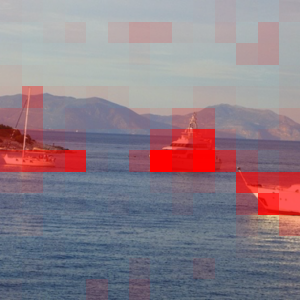

LOGITS = -6.13

MIN VALUE = 0.00, MAX VALUE = 0.04

The prediction mask of the BOAT regions is quite rough and lacks fine details compared to the ground truth. The boundaries of the BOAT on the left are significantly less defined, with portions of the BOAT missing in the prediction. The BOAT in the center is also over-extended towards the right, while the BOAT on the right is incomplete and fragmented in the prediction.

---

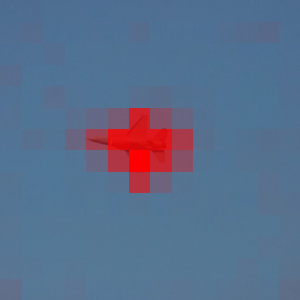

LOGITS = -1.90

MIN VALUE = 0.00, MAX VALUE = 0.08

The prediction mask of the AEROPLANE region is quite accurate overall, closely following the ground truth shape. However, the boundary of the AEROPLANE is not as sharp as in the ground truth, appearing slightly blurred and less defined, particularly along the tail section.

---

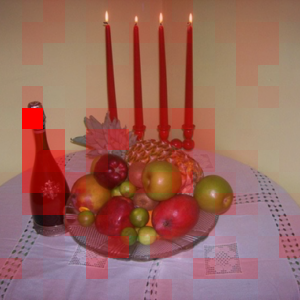

LOGITS = -21.09

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask of the BOTTLE region is quite inaccurate. The segmentation is incomplete, missing a significant portion of the bottle's body, especially towards the bottom. The boundary is also quite jagged and irregular, deviating considerably from the smooth shape of the ground truth.

---

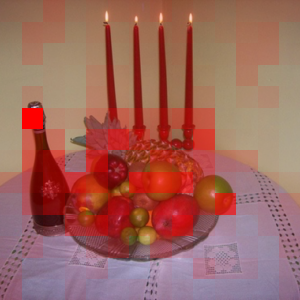

LOGITS = -13.35

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction mask for the CHAIR region is quite accurate overall, but the boundaries are somewhat jagged and less defined compared to the ground truth. There's a noticeable difference in the smoothness of the edges, particularly around the fruit and the base of the CHAIR.

---

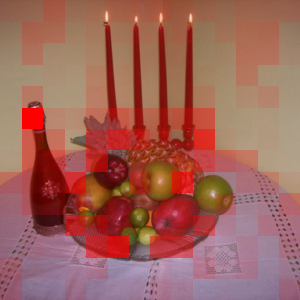

LOGITS = -11.41

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask largely captures the DININGTABLE region, but the segmentation is quite coarse and lacks precision. The boundary of the DININGTABLE is irregular and over-extended towards the bottom of the scene.

---

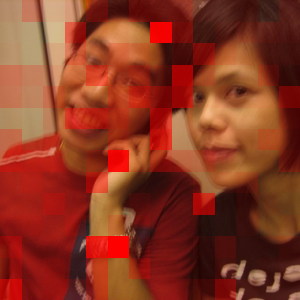

LOGITS = -7.75

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask of the PERSON region is quite fragmented, with several holes and discontinuities compared to the ground truth. The ground truth PERSON region is mostly captured, but the prediction misses several parts, especially around the face and hair.

---

In [18]:
cs_pr_image_text_list = [compute_maps_with_captions(model, ovr_mask_prs, answers_pr_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize) for ovr_mask_prs, answers_pr_text in zip(cs_ovr_mask_prs, cs_answers_pr_text)]
display_prompt(flatten_list(cs_pr_image_text_list))

# Token Length Analysis

**Ground truths** (non-splitted):

In [19]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
captions = [a['content'] for a in answers_gt]
tok_lengths = [model.count_tokens(t) for t in captions]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

80

critical_answers_amount=4


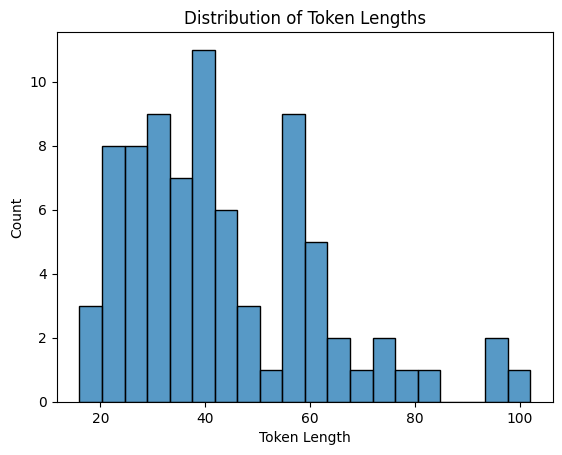

In [20]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Class-splitted predictions**:

In [21]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
answers_pr = flatten_class_splitted_answers(get_many_answer_pr(prs_path, return_state=False))
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

144

critical_answers_amount=2


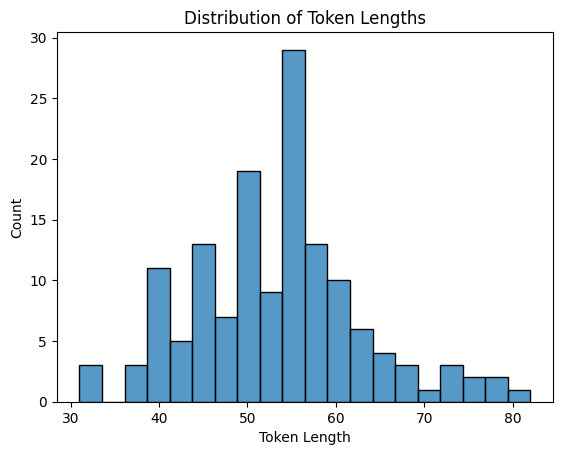

In [22]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Non-splitted predictions**:

In [23]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/non-splitted/answer_prs/gemini-2.0-flash/baseline/SepMasks_Ovr.jsonl")
answers_pr = get_many_answer_pr(prs_path, return_state=False)
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

77

critical_answers_amount=3


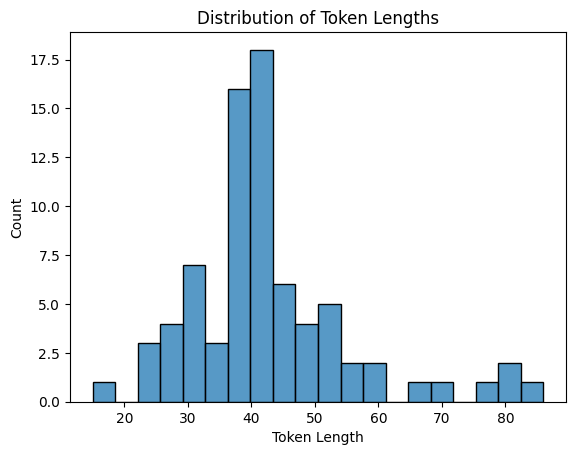

In [24]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

# Demo

In [25]:
map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST

(453, 604)


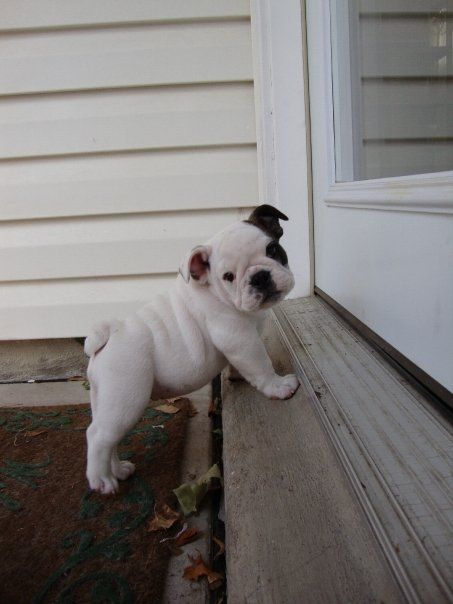

In [26]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
# image = Image.open("/home/olivieri/exp/resources/frappuccino.png")
print(image.size)
image

In [27]:
image_tensor = model.preprocess_fn(image).to(CONFIG['device'])
images_tensor = torch.stack([image_tensor]*4, dim=0)
images_tensor.shape

torch.Size([4, 3, 224, 224])

In [28]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
    # "The background, though blurred, reveals a parking lot filled with cars.",
    # "Despite the background, the frappuccino remains the star of the image."
]).to(CONFIG['device'])

In [29]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.get_logits(images=images_tensor, texts=texts_tensor, broadcast=False)

flair_logits # [4.4062,  6.9531, -20.5000, -18.1719]

tensor([[  4.3906],
        [  6.9531],
        [-20.5000],
        [-18.1719]], device='cuda:0', dtype=torch.float16)

In [30]:
attn_maps, min_value, max_value = model.get_maps(images_tensor, texts_tensor, map_compute_mode=MapComputeMode.ATTENTION, upsample_size=image.size[::-1], upsample_mode=map_resize_mode, broadcast=False)
attn_maps.shape

torch.Size([4, 1, 604, 453])

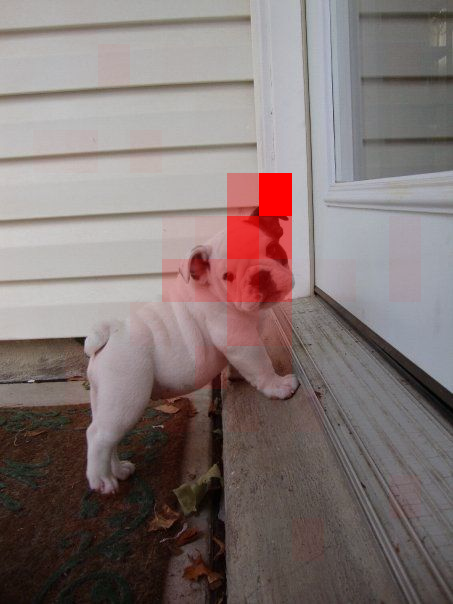

In [31]:
overlay_map(image, attn_maps[0])